# Machine Learning Project: Car Price Prediction 

## Submitted By:
Gal Ben Lulu - 314668393
  |  Rotem Barel - 318223872  |  https://github.com/RotemBarel1234/Gal_Rotem_Project_ML.git

## Import libraries:

In [457]:
# ספריות לניהול ועיבוד נתונים
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup
import requests
import time
import datetime
import pandas as pd
import smtplib
import csv
import os
import re
from IPython.display import display
from datetime import datetime, timedelta
from collections import defaultdict
import pandas as pd
from googletrans import Translator
import time
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from scipy import stats
pd.options.mode.chained_assignment=None
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

## Ensuring Model Integrity: The Importance of Separating Training and Test Data in Machine Learning

For our project, we followed a structured workflow focusing on data preparation and modeling. We began by splitting the data into training and test sets to prevent data leakage during model training. Our "prepare_data" function was crafted to seamlessly handle any dataset input, ensuring consistent preprocessing using the "transform" method, which learns from and applies transformations based solely on the training data. This approach guarantees that our machine learning model remains robust and unbiased when applied to new data for predictions.

## Prepare the train set 

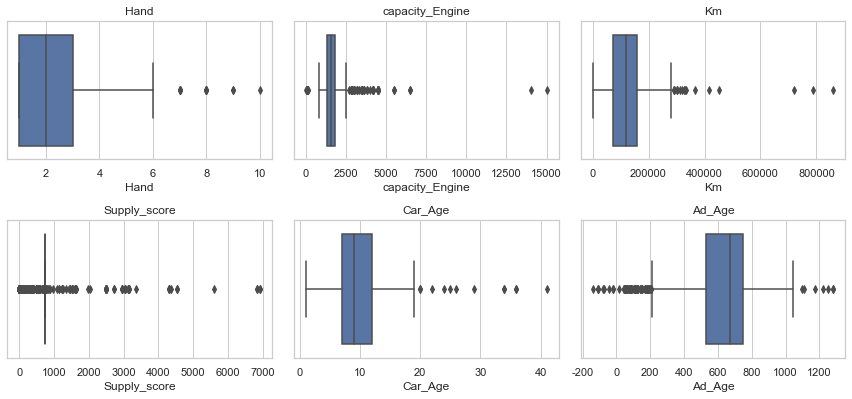

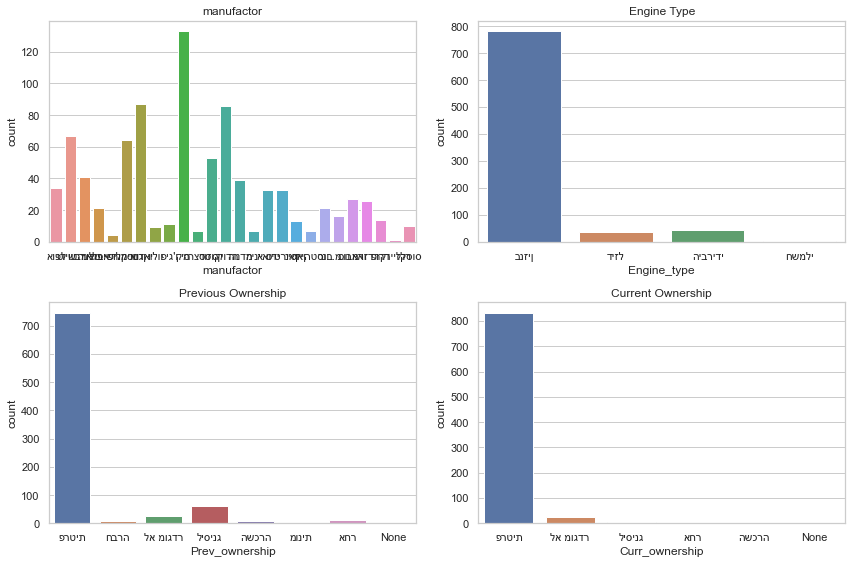

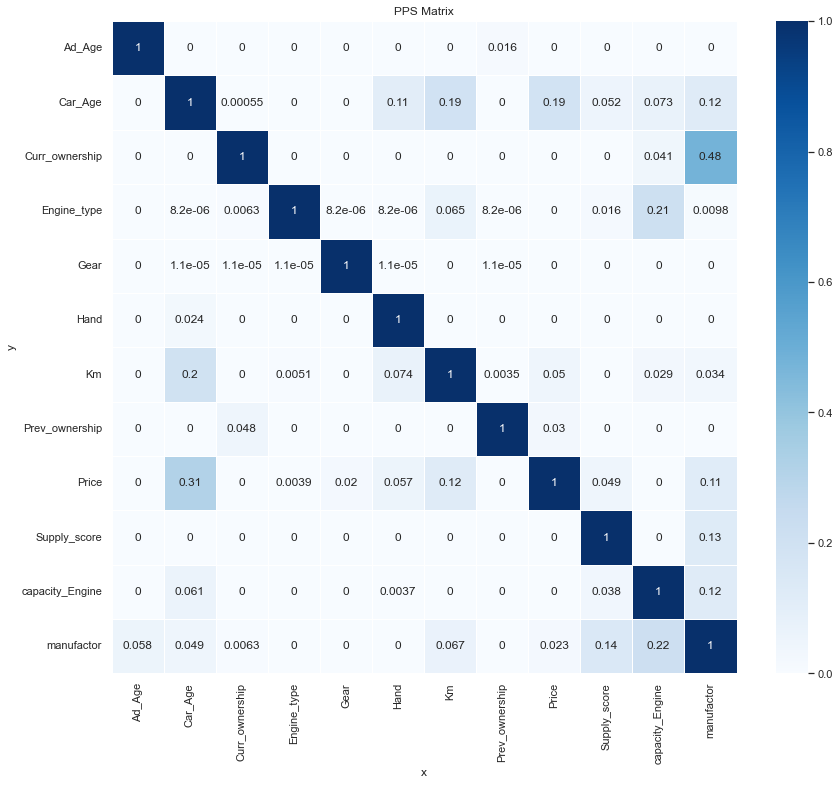

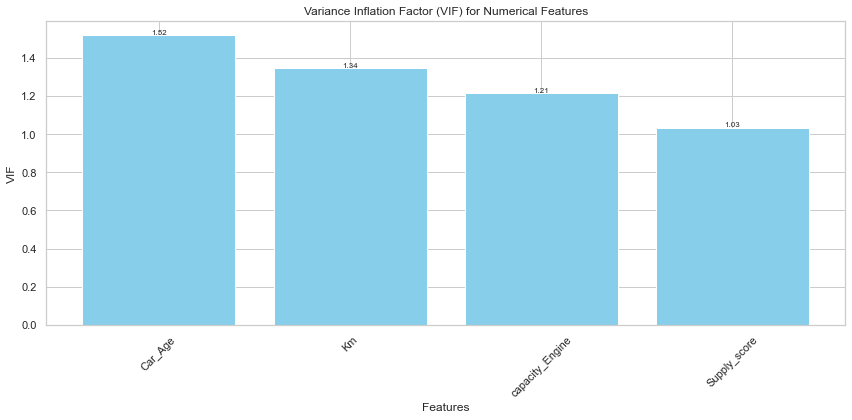

In [469]:
def convert_excel_date(excel_date):
    if isinstance(excel_date, (int, float)):
        return pd.to_datetime('1899-12-30') + pd.to_timedelta(excel_date, 'D')
    else:
        try:
            return pd.to_datetime(excel_date)
        except (ValueError, TypeError):
            return pd.NaT 

url = "C:\\Users\\Rotem\\Desktop\\dataset.csv"

# Reading the data from the file
df = pd.read_csv(url)
df = df.drop_duplicates()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df.isnull().sum()/df.shape[0]*100

# Convert types
train_df['manufactor'] = train_df['manufactor'].astype(str)
train_df['Year'] = pd.to_numeric(train_df['Year'], errors='coerce').astype('Int64')
train_df['model'] = train_df['model'].astype(str)
train_df['Hand'] = pd.to_numeric(train_df['Hand'], errors='coerce').astype('Int64')
train_df['Gear'] = pd.Categorical(train_df['Gear'])
train_df['capacity_Engine'] = pd.to_numeric(train_df['capacity_Engine'], errors='coerce').astype('Int64')
train_df['Engine_type'] = pd.Categorical(train_df['Engine_type'])
train_df['Prev_ownership'] = pd.Categorical(train_df['Prev_ownership'])
train_df['Curr_ownership'] = pd.Categorical(train_df['Curr_ownership'])
train_df['Area'] = train_df['Area'].astype(str, errors='ignore')
train_df['City'] = train_df['City'].astype(str)
train_df['Price'] = pd.to_numeric(train_df['Price'], errors='coerce').astype(float)
train_df['Pic_num'] = pd.to_numeric(train_df['Pic_num'], errors='coerce').fillna(0).astype(int)
train_df['Description'] = train_df['Description'].astype(str)
train_df['Color'] = train_df['Color'].astype(str)
train_df['Km'] = pd.to_numeric(train_df['Km'], errors='coerce').astype('Int64')
train_df['Test'] = pd.to_numeric(train_df['Test'], errors='coerce').astype('Int64')
train_df = train_df.replace('NA', np.nan)

# Convert Excel dates for train dataset
train_df['Cre_date'] = train_df['Cre_date'].apply(convert_excel_date)
train_df['Repub_date'] = train_df['Repub_date'].apply(convert_excel_date)

# Data values corrections

# Gear 
train_df['Gear'] = train_df['Gear'].replace('לא מוגדר', np.nan)
train_df['Gear'] = train_df['Gear'].replace('אוטומט', 'אוטומטית')

# Engine_type
train_df['Engine_type'] = train_df['Engine_type'].replace('היבריד', 'היברידי')
train_df['Engine_type'] = train_df['Engine_type'].replace('טורבו דיזל', 'דיזל')

# manufactor
train_df['manufactor'] = train_df['manufactor'].replace('Lexsus',"לקסוס")

# Drop irrelevant columns for train dataset
columns_to_drop = ['model', 'Description', 'City', 'Area', 'Color', 'Repub_date', 'Pic_num', 'Test']
train_df = train_df.drop(columns=columns_to_drop)

# Calculate Car_Age and Ad_Age for train dataset (instead of "Year" and "Cre_date" columns)
current_year = datetime.now().year
current_date = datetime.now()
train_df['Car_Age'] = current_year - train_df['Year']
train_df['Ad_Age'] = (current_date - train_df['Cre_date']).dt.days
columns_to_drop = ["Year", "Cre_date"]
train_df = train_df.drop(columns=columns_to_drop)


# Imputation of missing values in the train set:

# Km - Calculate average kilometers per year and multiply by car's age for missing Km values
missing_km = train_df['Km'].isnull()
avg_km_per_year = round((train_df['Km'] / train_df['Car_Age']).mean())
train_df.loc[missing_km, 'Km'] = train_df.loc[missing_km, 'Car_Age'] * avg_km_per_year

# Supply Score
supply_imputer = SimpleImputer(strategy='mean')
train_df['Supply_score'] = supply_imputer.fit_transform(train_df[['Supply_score']])

# Ad_Age - Impute missing values with mean
mean_imputer = SimpleImputer(strategy='mean')
train_df[['Ad_Age']] = mean_imputer.fit_transform(train_df[['Ad_Age']])

# Engine capacity - Impute missing values with median
median_imputer = SimpleImputer(strategy='median')
train_df['capacity_Engine'] = median_imputer.fit_transform(train_df[['capacity_Engine']])

# Gear, Engine_type, Prev_ownership, Curr_ownership - Impute missing values with most frequent
mode_imputer = SimpleImputer(strategy='most_frequent')
train_df[['Gear', 'Engine_type', 'Prev_ownership', 'Curr_ownership']] = mode_imputer.fit_transform(train_df[['Gear', 'Engine_type', 'Prev_ownership', 'Curr_ownership']])

# Spliting the train data
X_train = train_df.drop(columns=['Price'])
y_train = train_df['Price']

# Select numeric columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

# Create boxplots for each numeric column
plt.figure(figsize=(12, 8))  

for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)  
    sns.boxplot(x=X_train[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, columns, z_threshold = 2):
    df_clean = df.copy()
    for col in columns:
        if pd.api.types.is_numeric_dtype(df_clean[col]):
            # Check for NaN values
            col_values = df_clean[col].dropna().astype(float)
            # Calculate Z-scores
            z_scores = np.abs(stats.zscore(col_values))
            # Identify outliers based on threshold
            non_outliers = z_scores < z_threshold
            # Apply the mask back to the original DataFrame
            df_clean = df_clean[df_clean.index.isin(col_values.index[non_outliers])]
    return df_clean

# List of all numeric columns
numeric_cols = ['Hand', 'capacity_Engine', 'Km', 'Supply_score', 'Car_Age', 'Ad_Age']

# Removing outliers from train_df
train_df = remove_outliers_zscore(train_df, numeric_cols)

# Scaling the data
scaler = StandardScaler()
numerical_cols = ['Supply_score', 'Ad_Age', "Km", "capacity_Engine", "Hand", "Car_Age"]
#scaler.fit(train_df[numerical_cols])
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])


# Setting the size of the charts
plt.figure(figsize=(12, 8))

# Bar plot for 'Gear' and 'Engine_type'
plt.subplot(2, 2, 1)
sns.countplot(data=train_df, x='manufactor')
plt.title('manufactor')

plt.subplot(2, 2, 2)
sns.countplot(data=train_df, x='Engine_type')
plt.title('Engine Type')

# Barplot for 'Prev_ownership' and 'Curr_ownership'
plt.subplot(2, 2, 3)
sns.countplot(data=train_df, x='Prev_ownership')
plt.title('Previous Ownership')

plt.subplot(2, 2, 4)
sns.countplot(data=train_df, x='Curr_ownership')
plt.title('Current Ownership')

plt.tight_layout()
plt.show()


# Changing the values government, rental, company to "other" value
train_df['Prev_ownership'].replace(['מונית','ליסינג','ממשלתי' ,'השכרה', 'חברה'], 'אחר', inplace=True)
train_df['Prev_ownership'].replace(['None','לא מוגדר'],'פרטית', inplace=True)

# Replace specific values in the 'Gear' column of train_df with 'other'
train_df['Gear'].replace(['טיפטרוניק','ידנית' ,'רובוטית',], 'אחר', inplace=True)

# Replace specific values in the 'Engine_type' column of train_df with 'other'
train_df['Engine_type'].replace(['דיזל','היברידי','חשמלי' ,'גז'], 'אחר', inplace=True)

predictors_df = pps.predictors(train_df, y="Price")
matrix_df = pps.matrix(train_df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

#PPS 
plt.figure(figsize=(14, 12))  # Set the figure size (adjust width and height as needed)
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.title('PPS Matrix')  # Add title to the plot
plt.show()
numerical_features = ['Car_Age', 'capacity_Engine','Km', 'Supply_score']

# Function to calculate Variance Inflation Factor (VIF) for the specified columns in a DataFrame `df`.
def calculate_vif(df, cols):
    # Convert all columns to float64
    df_numeric = df[cols].astype(float)
    
    # Calculate VIF
    vif = pd.DataFrame()
    vif["Feature"] = cols
    vif["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
    return vif

# Now use the function
vif_result = calculate_vif(train_df, numerical_features)
vif_result = vif_result.sort_values('VIF', ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(vif_result['Feature'], vif_result['VIF'], color='skyblue')
plt.title('Variance Inflation Factor (VIF) for Numerical Features')
plt.xlabel('Features')
plt.ylabel('VIF')
plt.xticks(rotation=45, ha='center')  # Align xticks to center
plt.tight_layout()

# Add values above bars
for bar, vif_value in zip(bars, vif_result['VIF']):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{vif_value:.2f}', 
             ha='center', va='bottom', fontsize=8)

plt.show()

# One hot encoder for categorical variables in train set-
one = OneHotEncoder(handle_unknown='ignore', sparse=False)
one.fit(train_df[["manufactor", 'Prev_ownership', "Engine_type"]])
one_train = pd.DataFrame(one.transform(train_df[["manufactor",'Prev_ownership' , "Engine_type"]]), columns=list(one.get_feature_names()))

# Identify encoded columns for each variable
manufactor_columns = [col for col in one_train.columns if col.startswith('x0_')]
gear_columns = [col for col in one_train.columns if col.startswith('x1_')]
engine_type_columns = [col for col in one_train.columns if col.startswith('x2_')]
    
# Remove the first column from each encoded group
columns_to_drop = [manufactor_columns[0], gear_columns[0], engine_type_columns[0]]
one_train_reduced = one_train.drop(columns=columns_to_drop)
    
train_df = pd.concat([train_df.drop(columns=["manufactor", 'Prev_ownership', "Engine_type"]).reset_index(drop=True), one_train_reduced], axis=1)


## Insights from the plots

### Box plot- 

 We chose to present a Box Plot for the numeric columns to visually summarize the distribution of the data. The Box Plot helps identify outliers, understand the spread and central tendency of the data, and compare the distributions across different columns. 



### PPS:

We use a PPS plot  to understand the predictive strength of each feature with respect to the target variable. The PPS plot helps us identify:

1. Relevant Features: It highlights features that have strong predictive power, which are likely to be important for the model: Car_Age (0.30) , Km (0.12) , manufactor (0.098)

2. Irrelevant Features: It helps identify features with little to no predictive power, which can be excluded to reduce noise and improve model performance : Curr_ownership (0.0), Gear (0.013), Ad_Age shows no predictive power for any other variable including Price. From this plot we decided to remove these features from our model


### VIF: 
 we chose to use a Variance Inflation Factor (VIF) analysis for several important reasons:

Multicollinearity Detection: We use VIF to help identify multicollinearity among independent variables. Multicollinearity can lead to unstable and unreliable coefficient estimates in regression models.

Feature Selection: VIF aids in selecting the most relevant features while avoiding redundancy, which can improve model performance and interpretability.
 
All features show VIF values below 5, which is generally considered acceptable

### Distribution of Categorical Variables: 

We created bar plots for all the categorical variables. For the Prev_ownership and Engine_type columns, we observed that most of the values are concentrated in a single category, with very few values in the other categories. This uneven distribution makes accurate prediction more challenging. Therefore, we chose to convert these two variables to their most frequent value and classify all other values as "Other."


### One-Hot Encoding Explanation:
When performing One-Hot Encoding, we exclude the first column of each categorical variable to prevent multicollinearity. By removing one column, we ensure that the model does not redundantly encode the same information in multiple columns, thereby improving the model's stability and interpretability.

## Prepare the data set 

In [459]:
def prepare_data(df):
    #df['manufactor'] = df['manufactor'].astype(str)
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    df['model'] = df['model'].astype(str)
    df['Hand'] = pd.to_numeric(df['Hand'], errors='coerce').astype('Int64')
    df['Gear'] = pd.Categorical(df['Gear'])
    df['capacity_Engine'] = pd.to_numeric(df['capacity_Engine'], errors='coerce').astype('Int64')
    df['Engine_type'] = pd.Categorical(df['Engine_type'])
    df['Prev_ownership'] = pd.Categorical(df['Prev_ownership'])
    df['Curr_ownership'] = pd.Categorical(df['Curr_ownership'])
    df['Area'] = df['Area'].astype(str, errors='ignore')
    df['City'] = df['City'].astype(str)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce').astype(float)
    df['Pic_num'] = pd.to_numeric(df['Pic_num'], errors='coerce').fillna(0).astype(int)
    df['Description'] = df['Description'].astype(str)
    df['Color'] = df['Color'].astype(str)
    df['Km'] = pd.to_numeric(df['Km'], errors='coerce').astype('Int64')
    df['Test'] = pd.to_numeric(df['Test'], errors='coerce').astype('Int64')

    #arrange the columns
    df['Cre_date'] = df['Cre_date'].apply(convert_excel_date)
    df['Repub_date'] = df['Repub_date'].apply(convert_excel_date)
    df['Engine_type'] = df['Engine_type'].replace('היבריד', 'היברידי')
    df['Engine_type'] = df['Engine_type'].replace('טורבו דיזל', 'דיזל')
    df['Engine_type'].replace(['דיזל','היברידי','חשמלי' ,'גז'], 'אחר', inplace=True)
    df['manufactor'] = df['manufactor'].replace('Lexsus',"לקסוס")
    df['Gear'] = df['Gear'].replace('אוטומט', 'אוטומטית')
    df['Gear'].replace(['טיפטרוניק'"לא מוגדר",'ידנית' ,'רובוטית',], 'אחר', inplace=True)
    
    # Calculate Car_Age and Ad_Age for the dataset
    current_year = datetime.now().year
    current_date = datetime.now()
    df['Car_Age'] = current_year - df['Year']
    df['Ad_Age'] = (current_date - df['Cre_date']).dt.days
    columns_to_drop = ["Year", "Cre_date"]
    df = df.drop(columns=columns_to_drop)
 
    # Imputation of missing values 
    # Km - Use average kilometers per year from train dataset and multiply by car's age for missing Km values
    missing_km = df['Km'].isnull()
    df.loc[missing_km, 'Km'] = df.loc[missing_km, 'Car_Age'] * avg_km_per_year


    # Supply Score - Fill missing values using KNNImputer trained on train dataset
    df["Supply_score"] = supply_imputer.transform(df[['Supply_score']])

    # Ad_Age - Impute missing values with mean
    df[['Ad_Age']] = mean_imputer.transform(df[['Ad_Age']])

    # Engine capacity - Impute missing values with median
    df['capacity_Engine'] = median_imputer.transform(df[['capacity_Engine']])

    # Gear, Engine_type, Prev_ownership, Curr_ownership - Impute missing values with most frequent
    df[['Gear', 'Engine_type', 'Prev_ownership', 'Curr_ownership']] = mode_imputer.transform(df[['Gear', 'Engine_type', 'Prev_ownership', 'Curr_ownership']])
    df['Prev_ownership'].replace(['מונית','ליסינג','ממשלתי' 'לא מוגדר','השכרה', 'חברה'], 'אחר', inplace=True)
    
    # List of all numerical columns
    numeric_cols = ['capacity_Engine', 'Km', 'Supply_score', 'Car_Age', "Hand", "Car_Age"]
    df['Supply_score'] = df['Supply_score'].astype(int)
    df['capacity_Engine'] = df['capacity_Engine'].astype(int)

    # Remove outliers using z-score from df
    df = remove_outliers_zscore(df, numeric_cols)

    
    # Scaling the data
    numeric_cols = ['Supply_score', 'Ad_Age', "Km", "capacity_Engine", "Hand", "Car_Age"]
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    df=df.drop(columns=[ "Hand", "Ad_Age"])
    
    columns_to_drop = ['model', 'Description', 'City', 'Area', 'Color', 'Repub_date', 'Pic_num', 'Test', "Curr_ownership", "Gear"]
    df = df.drop(columns=columns_to_drop)

    # One hot encoder for categorical variables in test set using the same encoder fitted on train set
    one_df = pd.DataFrame(one.transform(df[["manufactor", 'Prev_ownership', "Engine_type"]]), columns=list(one.get_feature_names()))

    # Identify encoded columns for each variable in test set
    manufactor_columns = [col for col in one_df.columns if col.startswith('x0_')]
    Prev_columns = [col for col in one_df.columns if col.startswith('x1_')]
    engine_type_columns = [col for col in one_df.columns if col.startswith('x2_')]

    # Remove the first column from each encoded group in test set
    columns_to_drop = [manufactor_columns[0], Prev_columns[0], engine_type_columns[0]]
    one_reduced = one_df.drop(columns=columns_to_drop)

    # Combine the original test set (without the original categorical columns) with the reduced one hot encoded columns
    df = pd.concat([df.drop(columns=["manufactor", 'Prev_ownership', "Engine_type"]).reset_index(drop=True), one_reduced], axis=1)

    return df

## Spliting the data:

In [460]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

df_train=prepare_data(df_train)
df_test=prepare_data(df_test)

X_train = df_train.drop(columns=['Price'])
y_train = df_train['Price']

X_test = df_test.drop(columns=['Price'])
y_test = df_test['Price']


In [461]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

# Define the range of alpha values to search over
alphas = [0.01,0.1, 0.5, 1.0, 5.0, 10.0,100.0]

# Create an ElasticNetCV model with 5-fold cross-validation
model = ElasticNetCV(cv=5, random_state=42, max_iter=10000, tol=1e-4, alphas=alphas, l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9])

# Fit the model on training data
model.fit(X_train, y_train)

# Get the best alpha and l1_ratio
best_alpha = model.alpha_
best_l1_ratio = model.l1_ratio_

# Print the best alpha and l1_ratio found
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")


Best alpha: 0.01
Best l1_ratio: 0.9
RMSE: 11859.66373924652


In [462]:
# ביצוע K-fold cross-validation עם 10 קיפולים
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# חישוב שורש הסכום הריבועי של הממוצע של ה- MSE בכל קיפול
cv_rmse_scores = np.sqrt(-cv_scores)

# הדפסת התוצאות
print(f'K-Fold Cross-Validation RMSE Scores: {cv_rmse_scores}')
print(f'Mean RMSE: {cv_rmse_scores.mean()}')
print(f'Standard Deviation of RMSE: {cv_rmse_scores.std()}')

K-Fold Cross-Validation RMSE Scores: [14371.23215187 13026.89784743 12822.45489421 13228.80103254
 14715.55195847 15003.94886754 12354.80506424 12460.66547367
 12371.9244222  13410.24558705]
Mean RMSE: 13376.65272992209
Standard Deviation of RMSE: 936.7533662335117


## Top Five Influential Features

In [463]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False).head(5)

,Feature,Importance
1,Km,0.347126
0,capacity_Engine,0.169039
3,Car_Age,0.160817
2,Supply_score,0.059943
29,x1_פרטית,0.037048


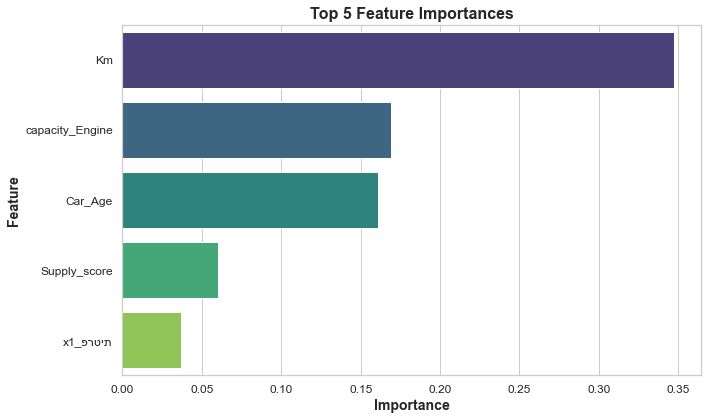

In [464]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(5)

# Set up the plot using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create barplot with dynamic hover data
bars = sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")

# Customize labels and title
plt.xlabel("Importance", fontsize=14, weight='bold')
plt.ylabel("Feature", fontsize=14, weight='bold')
plt.title("Top 5 Feature Importances", fontsize=16, weight='bold')

# Adjust tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Function to update title dynamically
def update_title(event):
    if event.xdata is not None and event.ydata is not None:
        for bar, importance, feature in zip(bars.patches, feature_importance_df['Importance'], feature_importance_df['Feature']):
            if bar.contains(event)[0]:
                plt.gca().set_title(f'{feature}: {importance:.2f}', fontsize=14)
                plt.draw()  # Redraw the plot to update the title

# Connect the function to the figure for dynamic hover
plt.gcf().canvas.mpl_connect('motion_notify_event', update_title)

# Display the plot
plt.tight_layout()
plt.show()


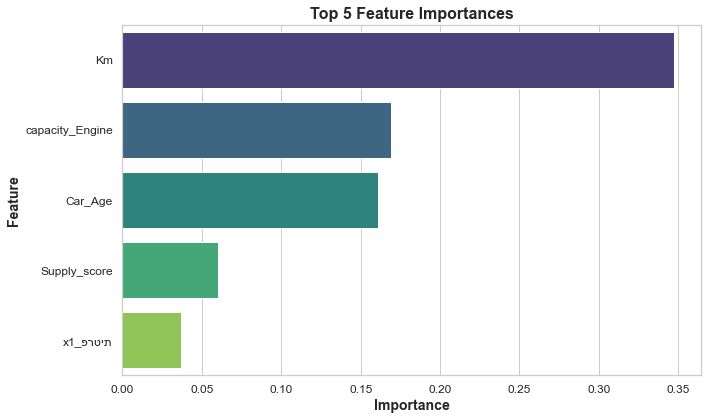

In [465]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Sorting feature importances in descending order and selecting the top 5
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(5)

# Setting up the plot using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Creating a barplot with dynamic hover data
bars = sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")

# Customizing labels and title
plt.xlabel("Importance", fontsize=14, weight='bold')
plt.ylabel("Feature", fontsize=14, weight='bold')
plt.title("Top 5 Feature Importances", fontsize=16, weight='bold')

# Adjusting tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Function to update title dynamically on hover
def update_title(event):
    if event.xdata is not None and event.ydata is not None:
        for bar, importance, feature in zip(bars.patches, feature_importance_df['Importance'], feature_importance_df['Feature']):
            if bar.contains(event)[0]:
                plt.gca().set_title(f'The best feature: {feature} - Importance: {importance:.2f}', fontsize=14)
                plt.draw()  # Redrawing the plot to update the title

# Connecting the hover function to the figure canvas
plt.gcf().canvas.mpl_connect('motion_notify_event', update_title)

# Displaying the plot
plt.tight_layout()
plt.show()
